In [1]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras



# LOAD DATA

In [3]:
df = pd.read_csv('datasetiot.csv')
# add columns empty columns to the dataframe this will be used to store the labels
df['label'] = np.nan
df['label'] = df['label'].astype('category')
#set category types
df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)
df.head()
# line 0 to 5150 is FTP traffic
df.loc[0:5150, 'label'] = 'FTP'
# line 5151 to 18600 is SSH traffic
df.loc[5151:18600, 'label'] = 'SSH'
# line 18601 to 28000 is FTP + SSH traffic
df.loc[18601:26429, 'label'] = 'FTP + SSH'
# line 28000 to 40100 is Keylogger traffic
df.loc[28000:40100, 'label'] = 'Keylogger'
# line 40101 to 46500 is FTP + SSH 
df.loc[40101:46500, 'label'] = 'FTP + SSH'
# line 46501 to 54100 is Reverse Shell
df.loc[46501:54100, 'label'] = 'Reverse Shell'
# line 54101 to 57150 is FTP + SSH
df.loc[54101:57150, 'label'] = 'FTP + SSH'
# the rest is syn flood
df.loc[57151:, 'label'] = 'SYN Flood'




C:\Users\enzoh\AppData\Local\Temp\ipykernel_41280\2390272622.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  df['label'].cat.set_categories(['FTP', 'SSH', 'FTP + SSH', 'Keylogger', 'Reverse Shell', 'SYN Flood'], inplace=True)


# Visulation of the data

In [27]:
# print column names
print(df.columns)

Index(['No.', 'Time', 'Source', 'Destination', 'Protocol', 'Length', 'Info',
       'label'],
      dtype='object')


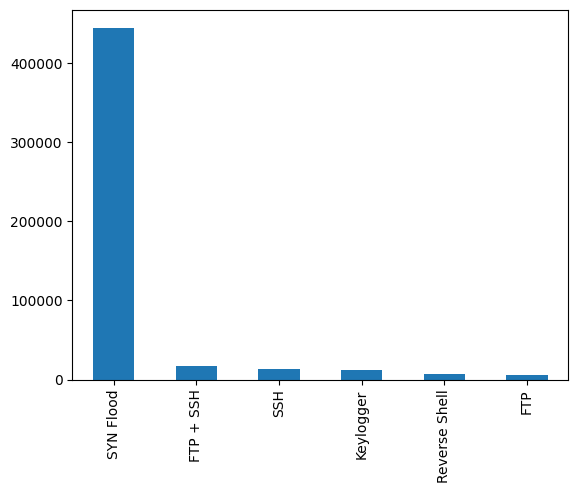

SYN Flood        445050
FTP + SSH         17279
SSH               13450
Keylogger         12101
Reverse Shell      7600
FTP                5151
Name: label, dtype: int64

In [4]:
# show and plot  the number of samples for each label
df['label'].value_counts().plot(kind='bar')
plt.show()
# show the number of samples for each label
df['label'].value_counts()


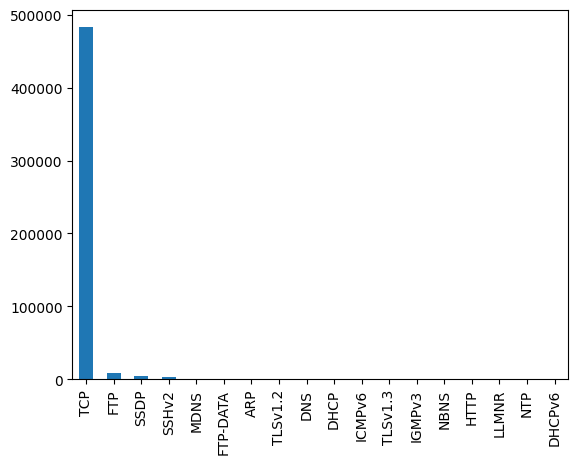

TCP         482847
FTP           8029
SSDP          4668
SSHv2         3806
MDNS           543
FTP-DATA       511
ARP            401
TLSv1.2        354
DNS            352
DHCP           136
ICMPv6         123
TLSv1.3        120
IGMPv3         112
NBNS            72
HTTP            49
LLMNR           48
NTP             24
DHCPv6           6
Name: Protocol, dtype: int64

In [5]:
# show count for each protocol
df['Protocol'].value_counts().plot(kind='bar')
plt.show()
# show count for each protocol
df['Protocol'].value_counts()


# LSTM model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 68,358
Trainable params: 68,358
Non-trainable params: 0
_________________________________________________________________


In [37]:
from sklearn.preprocessing import LabelEncoder

def prepare_data(df, window_size=128 ):
    """Prepare the data for the LSTM model. Normalize the data, and transform objects to numerical values.
       
        df: pandas dataframe
        window_size: the number of samples to put in a sequence
        batch_size: the number of sequences to put in a batch
    """
    # Initialize the input and output lists
    """
    Prepare LSTM data with sliding window sequences.

    Args:
        window_size (int): Number of packets in each window.
        df (pd.DataFrame): Input dataframe.

    Returns:
        Tuple: X, y
            - X (np.array): Features.
            - y (np.array): Labels.
    """

    # Extract relevant features
    X = df.drop('label', axis=1)  # Drop the label column
    y = df['label']

    # Label encoding for categorical columns
    label_encoder = LabelEncoder()
    X_encoded = X.apply(label_encoder.fit_transform)  # Apply label encoding to all columns

    # Create sliding window sequences of data
    X_sequences = []
    y_labels = []
    for i in range(len(X_encoded) - window_size + 1):
        X_sequences.append(X_encoded.iloc[i:i+window_size].values)
        y_labels.append(y.iloc[i+window_size-1])

    X_sequences = np.array(X_sequences)
    y_labels = np.array(y_labels)

    return X_sequences, y_labels
    





In [38]:
# Define the indices for training, validation, and test sets
train_indices = [(0, 3500), (5150, 13000), (18600, 24500), (28000, 35000), (40100, 44500), (46500, 51500), (int(54101), int((len(df)-54101)*0.8))]
val_indices = [(3501, 4300), (13001, 15500), (24501, 26500), (35001, 37500), (44501, 45000), (51501, 52000), (int((len(df)-54101)*0.8), int((len(df)-54101)*0.9))]
test_indices = [(4301, 5150), (15501, 18600), (26501, 28000), (37501, 40100), (45001, 46500), (52001, 54100), (int((len(df)-54101)*0.9), int(len(df)-54101))]

# create the training, validation, and test dataframes, including the parts inside each tuple
train_df = pd.concat([df.iloc[start:end] for start, end in train_indices])
val_df = pd.concat([df.iloc[start:end] for start, end in val_indices])
test_df = pd.concat([df.iloc[start:end] for start, end in test_indices])

# print shapes
print(train_df.shape, val_df.shape, test_df.shape)

# reset the indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


#print all dtypes
print(train_df.dtypes)
print(val_df.dtypes)
print(test_df.dtypes)
# window_size = 128
train_df_data, train_target = prepare_data(train_df)
# print("aaaaaaaaaaaaa",train_df_data.shape, train_target.shape)
# val_df_data, val_target = prepare_data(val_df)
# test_df_data, test_target = prepare_data(test_df)
# num_features = train_df_data.shape[2]




(338029, 8) (53604, 8) (56454, 8)
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object
No.               int64
Time            float64
Source           object
Destination      object
Protocol         object
Length            int64
Info             object
label          category
dtype: object


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [17]:
# train lstm model
input_shape = (window_size, num_features)

model = keras.Sequential()
model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(6, activation='relu'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()




NameError: name 'window_size' is not defined